# Primary goal is to run molecular dynamics using the trained MACE model 

We will again use inspiration from the MACE tutorial notebook to run molecular dynamics, but this will serve as an example of how we can use the trained model to select new configurations for future DFT calculations. 

In [1]:
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

import random
import os
import time
import numpy as np
import pylab as pl
from IPython import display

def simpleMD(init_conf, temp, calc, fname, s, T):
    """
    Run a simple molecular dynamics simulation using the Langevin thermostat.

    Parameters:
    init_conf (ase.Atoms): Initial atomic configuration.
    temp (float): Target temperature in Kelvin.
    calc (ase.Calculator): Calculator to use for the simulation.
    fname (str): Filename to save the trajectory.
    s (int): Interval for saving frames.
    T (int): Total number of steps to run the simulation.

    This function initializes the temperature of the system, sets up the Langevin
    dynamics, and runs the simulation while saving the trajectory and plotting
    the energy and temperature of the system.
    """

    init_conf.set_calculator(calc)
    #initialize the temperature
    random.seed(701) #just making sure the MD failure is reproducible
    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.2) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

In [2]:
# define the mace calculator 
from mace.calculators.mace import MACECalculator

model_paths = ['../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_0-11-06-fixedtest_stagetwo_compiled.model',
               '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_2-11-06-fixedtest_stagetwo_compiled.model',
               '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_4-11-06-fixedtest_stagetwo_compiled.model',
               '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_3-11-06-fixedtest_stagetwo_compiled.model']

mace_calcs = MACECalculator(model_paths=model_paths, device='cuda')

/home/myless/.miniforge3/envs/mace/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.loa

Running committee mace with 4 models


/home/myless/.miniforge3/envs/mace/lib/python3.10/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loca

No dtype selected, switching to float32 to match model dtype.


In [3]:
from ase.io import read
# get the training data
data =  read('../data/zr-w-v-ti-cr/gen_0_2024-11-06/2024-11-06_all_remaining_atoms.xyz',index=':')

# go through each configuration and calculate the force variance amongst the committees 
#for i,atoms in enumerate(data):


In [10]:
test_atoms = data[0].copy()
test_atoms.calc = mace_calcs

energies = test_atoms.get_potential_energies()
#print(energies)

#print(test_atoms.calc.results['forces_comm'])

import numpy as np

def calculate_total_variance(forces_comm):
    # Flatten the M x N x 3 array to M x (N*3) for variance calculation
    flattened_forces = forces_comm.reshape(forces_comm.shape[0], -1)
    # Calculate variance across models (axis=0)
    total_variance = np.var(flattened_forces, axis=0)
    # Sum the variances to get a single value for the entire structure
    return np.sum(total_variance)

def calculate_per_atom_variance(forces_comm):
    # Calculate variance across models (axis=0) for each atom
    per_atom_variance = np.var(forces_comm, axis=0)
    # Sum the variances of the x, y, z components for each atom
    return np.sum(per_atom_variance, axis=1)

# Example usage
#forces_comm = np.random.rand(5, 10, 3)  # Example data: 5 models, 10 atoms, 3 components
forces_comm = test_atoms.calc.results['forces_comm']
total_variance = calculate_total_variance(forces_comm)
per_atom_variance = calculate_per_atom_variance(forces_comm)

print(len(per_atom_variance))
print("Total Variance:", total_variance)
print("Per Atom Variance:", per_atom_variance)

124
Total Variance: 0.031633615
Per Atom Variance: [3.13075318e-04 1.30512548e-04 1.65907142e-04 5.52000129e-04
 2.96772050e-04 9.92627683e-05 5.19494643e-04 1.13314956e-04
 5.08104509e-04 2.52477650e-04 1.73207154e-04 4.72918327e-05
 2.98044324e-04 4.11556306e-04 5.00280439e-05 1.35820548e-04
 1.02092956e-04 1.32512170e-04 1.10657238e-04 1.23724501e-04
 1.41838391e-04 4.71156323e-04 2.45563802e-04 1.66371436e-04
 9.02205575e-05 2.24418582e-05 1.01965306e-04 2.75135884e-04
 1.04336868e-04 1.69903651e-04 2.97474180e-04 6.28341979e-04
 2.03005155e-04 9.05761379e-04 4.61234566e-04 7.93134095e-05
 3.98650853e-04 4.12180845e-04 2.50271085e-04 8.86610505e-05
 1.21337587e-04 6.40387443e-05 1.51067536e-04 1.85863144e-04
 1.97389134e-04 1.45758080e-04 8.20676447e-04 3.16750753e-04
 2.14160551e-04 1.27136562e-04 2.75970990e-04 4.29415057e-04
 1.53025379e-04 1.18855649e-04 2.73918646e-04 7.86034070e-05
 2.71620956e-04 9.06866844e-05 1.17208241e-04 1.19366952e-04
 6.94682822e-05 2.60190194e-04 1.8

In [15]:
# calculate for each atom the variance of the forces from the different models, rank them and select the top 25 structures with the highest variance 
var_data = {}
for i, atoms in enumerate(data):
    if i % 100 == 0:
        print(f"Processing configuration {i}/{len(data)}")
    atoms.calc = mace_calcs
    energies = atoms.get_potential_energies() # need to do this to initialize the calculator
    forces_comm = atoms.calc.results['forces_comm']
    total_variance = calculate_total_variance(forces_comm)
    per_atom_variance = calculate_per_atom_variance(forces_comm)
    var_data[i] = {'total_variance': total_variance, 'per_atom_variance': per_atom_variance}


# sort the data by total variance 
sorted_var_data = sorted(var_data.items(), key=lambda x: x[1]['total_variance'], reverse=True)

# select the top 25 structures 
top_structures = sorted_var_data[:25]

Processing configuration 0/8471
Processing configuration 100/8471
Processing configuration 200/8471
Processing configuration 300/8471
Processing configuration 400/8471
Processing configuration 500/8471
Processing configuration 600/8471
Processing configuration 700/8471
Processing configuration 800/8471
Processing configuration 900/8471
Processing configuration 1000/8471
Processing configuration 1100/8471
Processing configuration 1200/8471
Processing configuration 1300/8471
Processing configuration 1400/8471
Processing configuration 1500/8471
Processing configuration 1600/8471
Processing configuration 1700/8471
Processing configuration 1800/8471
Processing configuration 1900/8471
Processing configuration 2000/8471
Processing configuration 2100/8471
Processing configuration 2200/8471
Processing configuration 2300/8471
Processing configuration 2400/8471
Processing configuration 2500/8471
Processing configuration 2600/8471
Processing configuration 2700/8471
Processing configuration 2800/84

## Save the results

In [16]:
import json 
from monty.json import MontyEncoder
# save the sorted variance data to a json 
with open('../data/zr-w-v-ti-cr/gen_0_2024-11-06/top_structures_var_data.json', 'w') as f:
    json.dump(top_structures, f, cls=MontyEncoder)

with open('../data/zr-w-v-ti-cr/gen_0_2024-11-06/all_structures_var_data.json', 'w') as f:
    json.dump(sorted_var_data, f, cls=MontyEncoder)


## Load the Results

In [5]:
import json
top_structures = json.load(open('../data/zr-w-v-ti-cr/gen_0_2024-11-06/top_structures_var_data.json', 'r'))

In [8]:
from ase.io import write
# save the the top structures to an xyz file for visualization 
for i, atoms in enumerate(top_structures):
    write(f"../data/zr-w-v-ti-cr/gen_0_2024-11-06/top_structures/top_structure_{i}.xyz", data[top_structures[i][0]], format='extxyz')


## Run the MD 

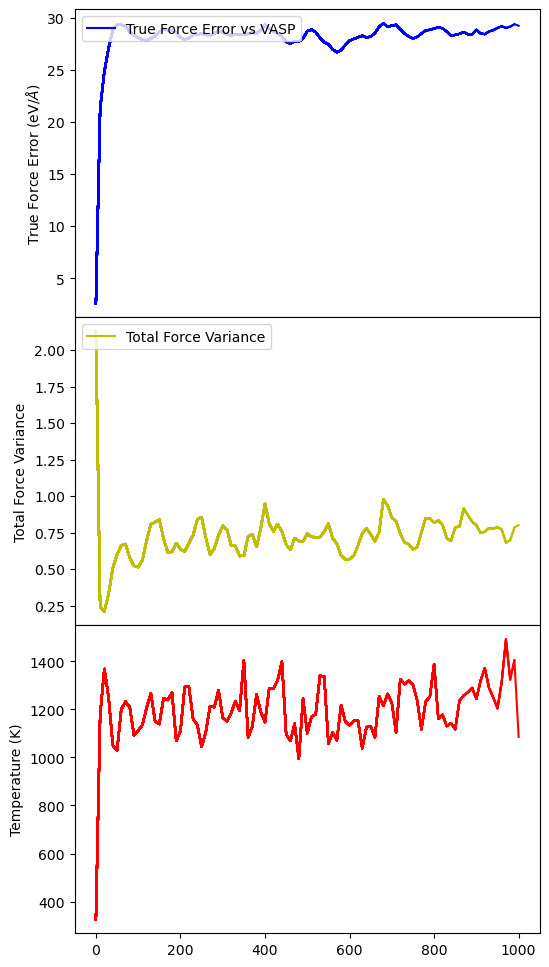

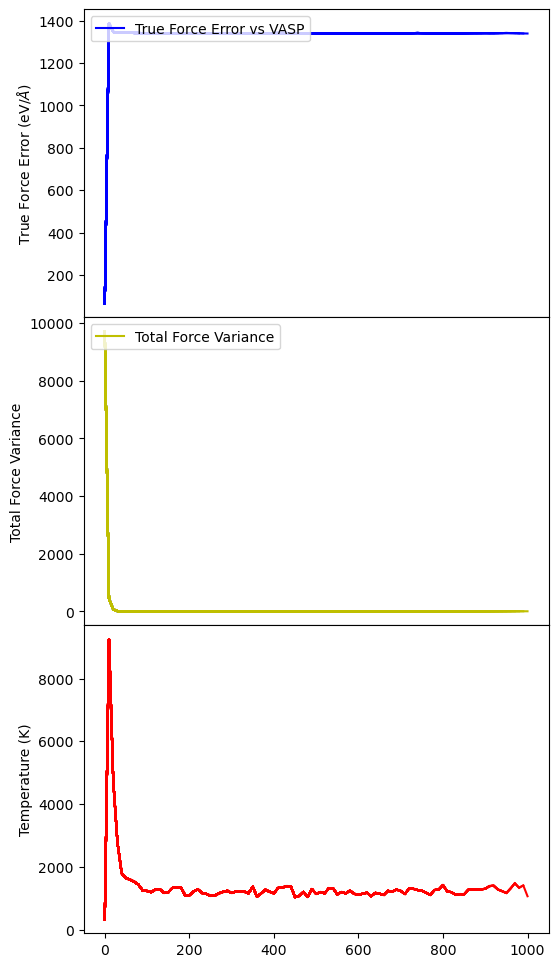

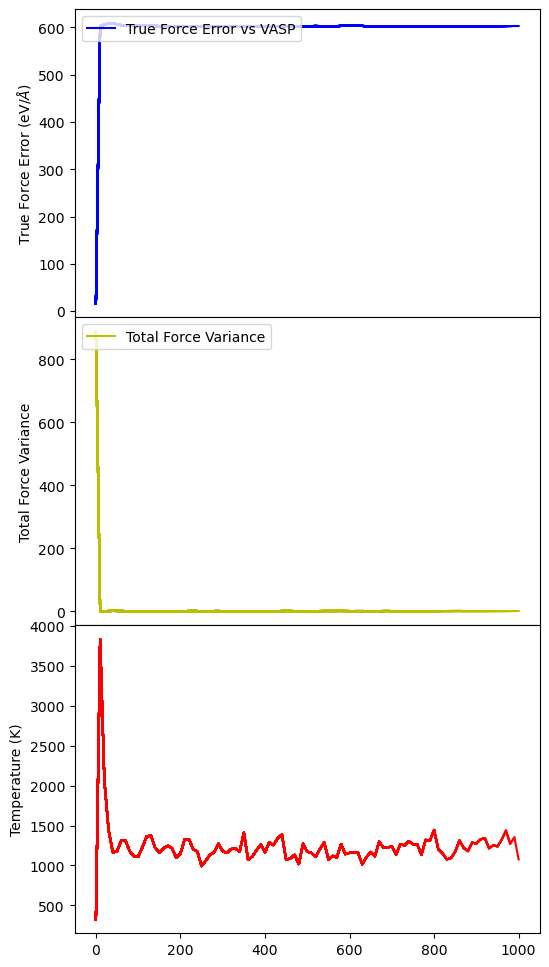

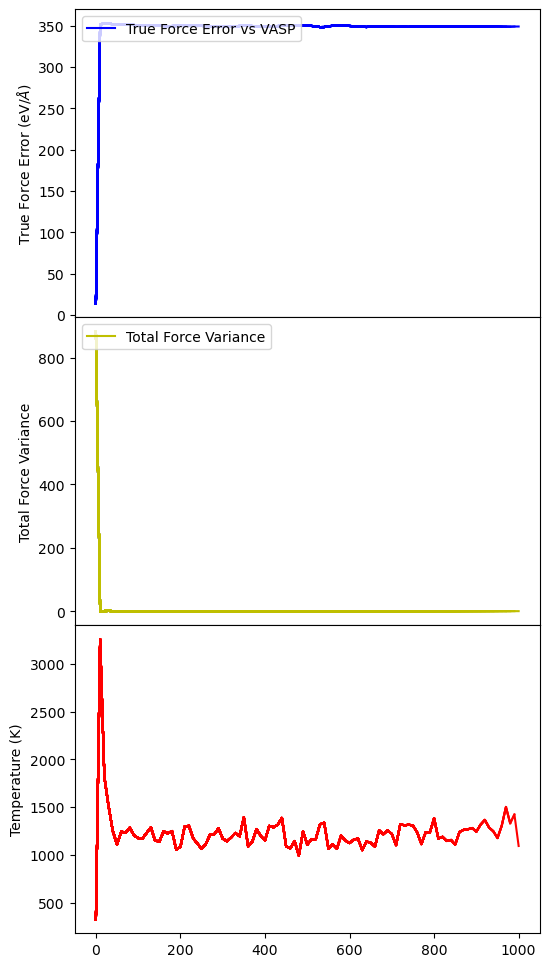

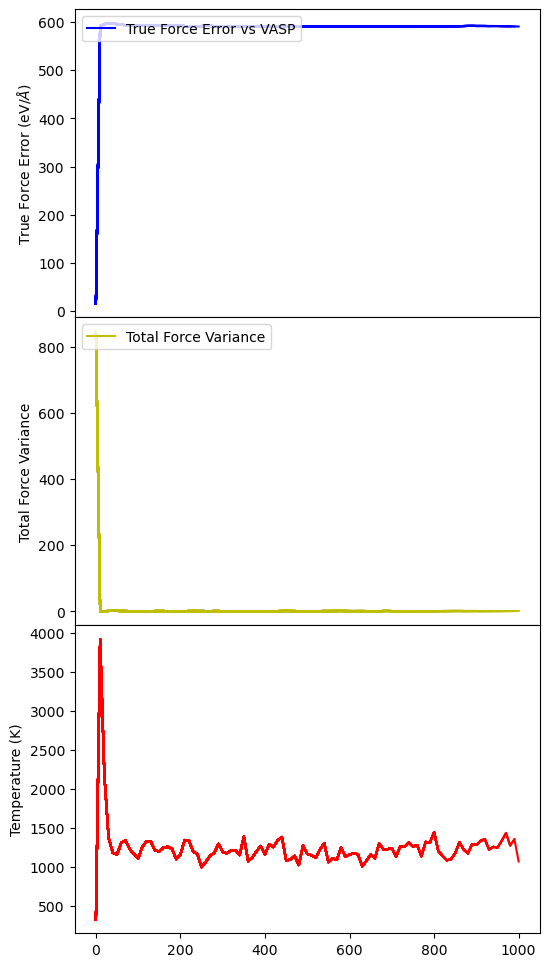

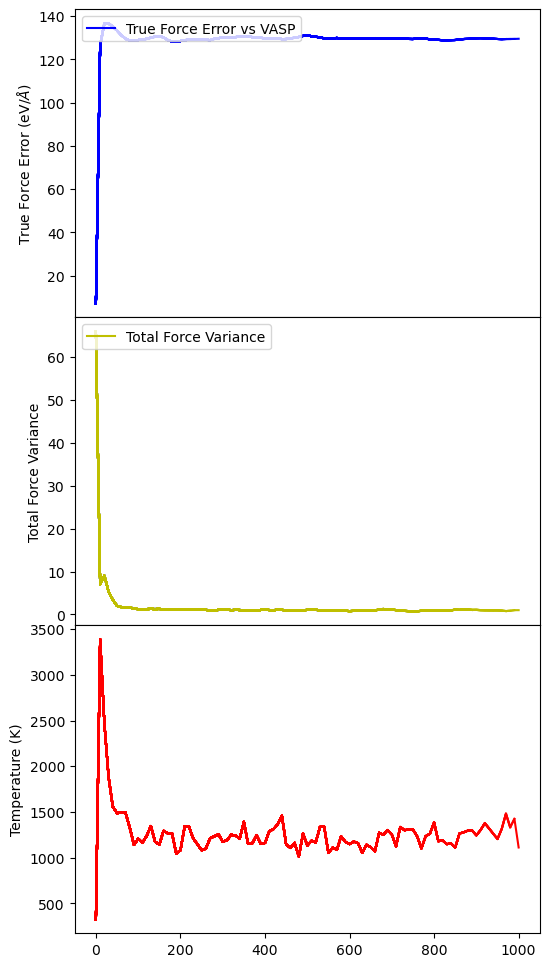

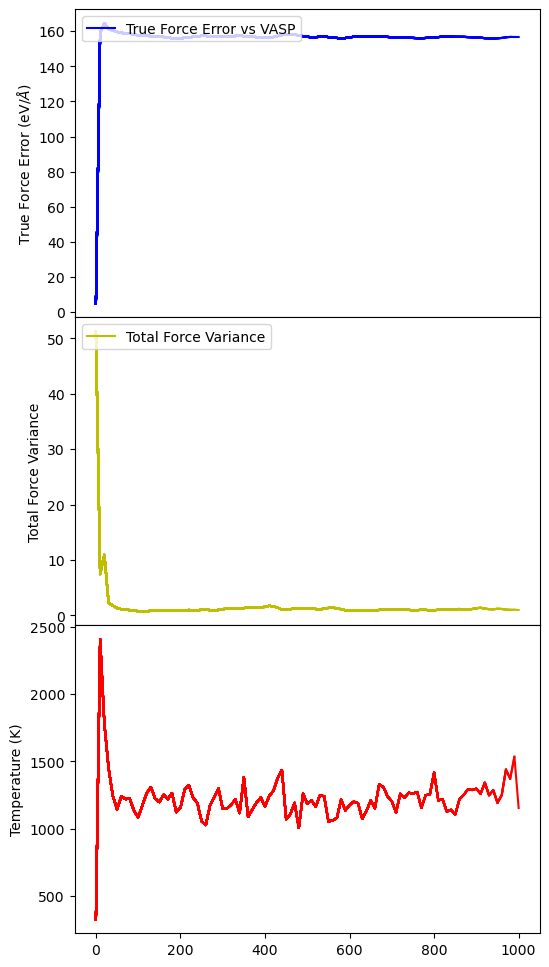

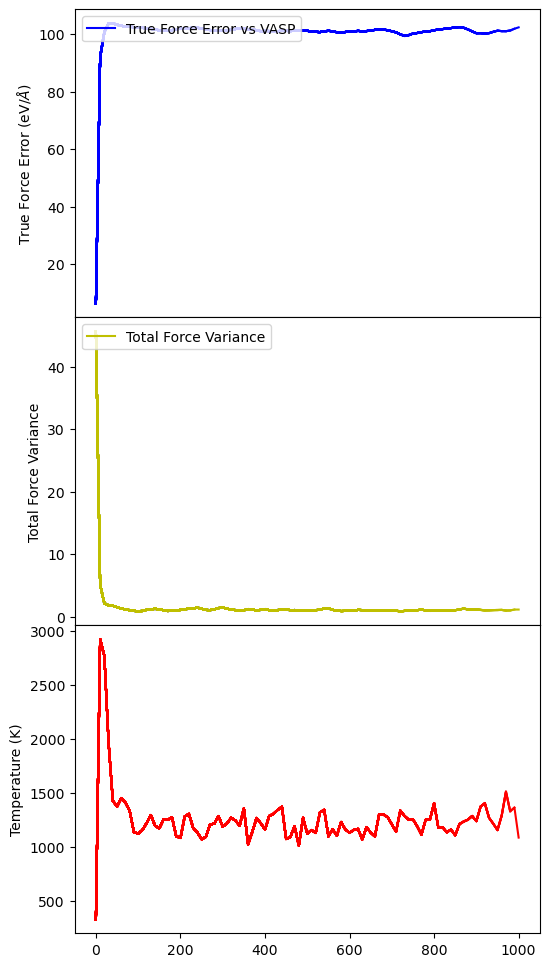

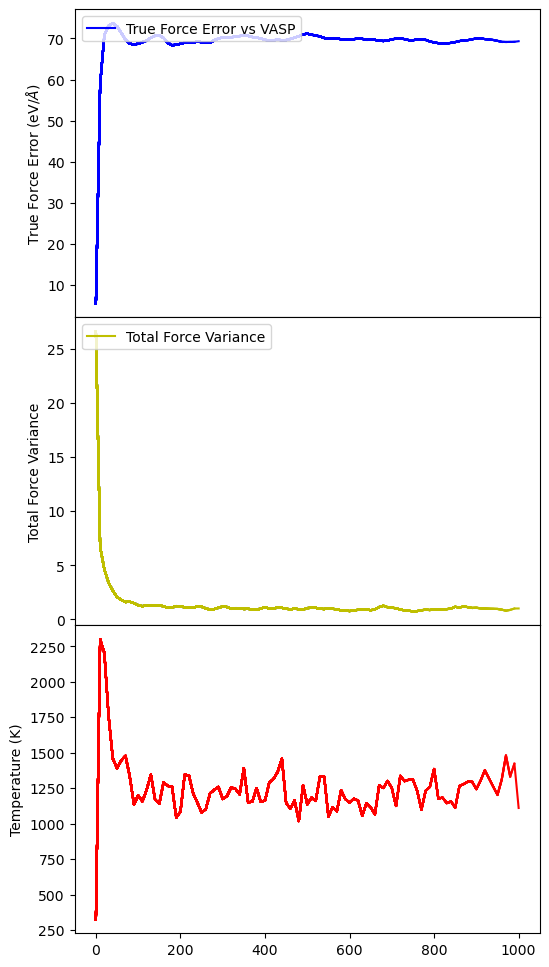

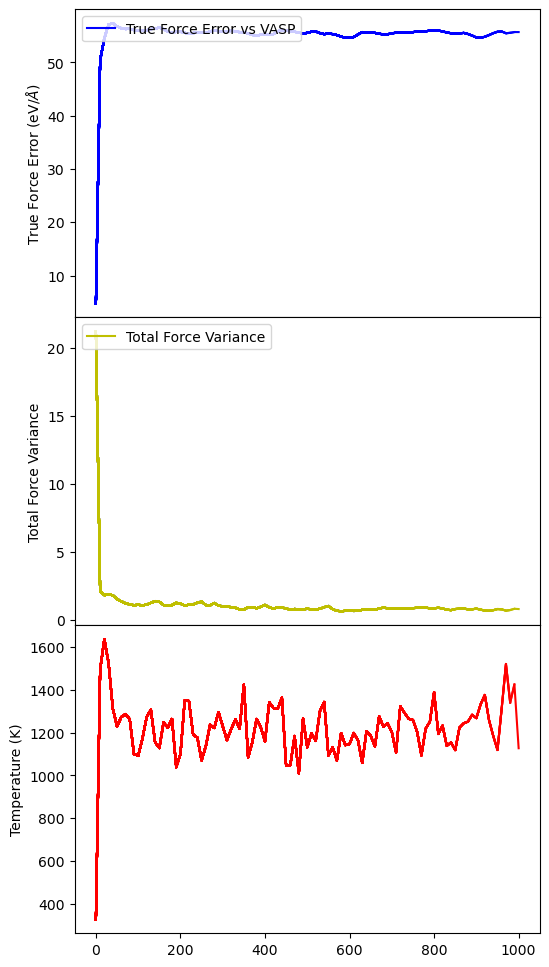

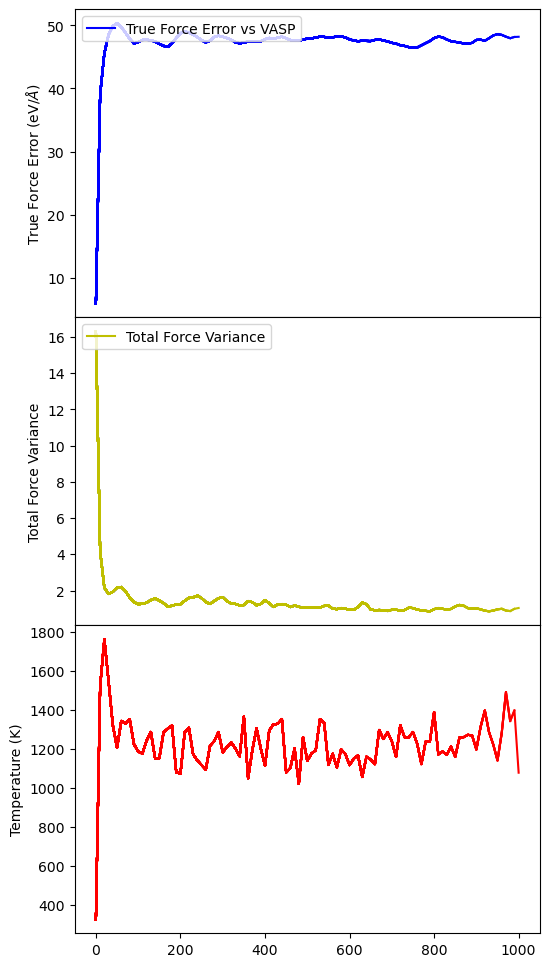

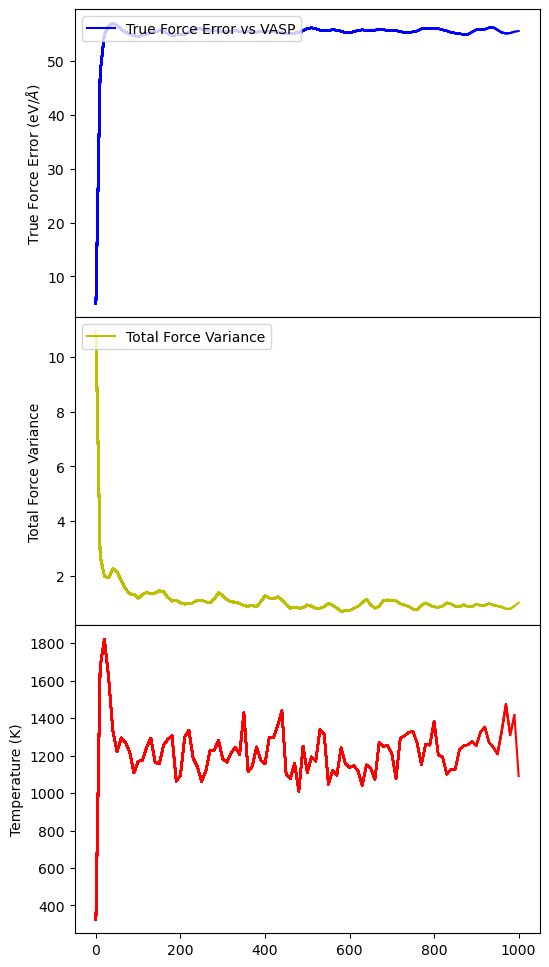

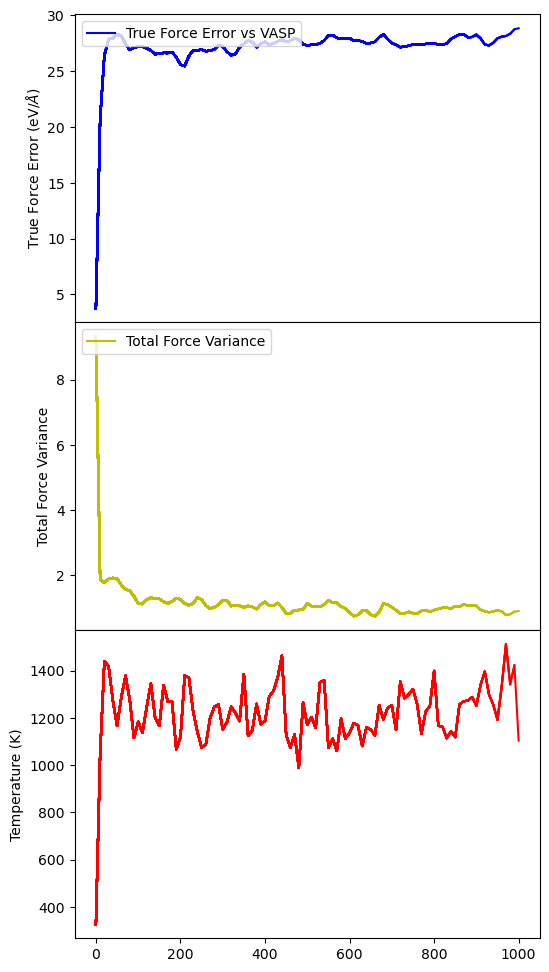

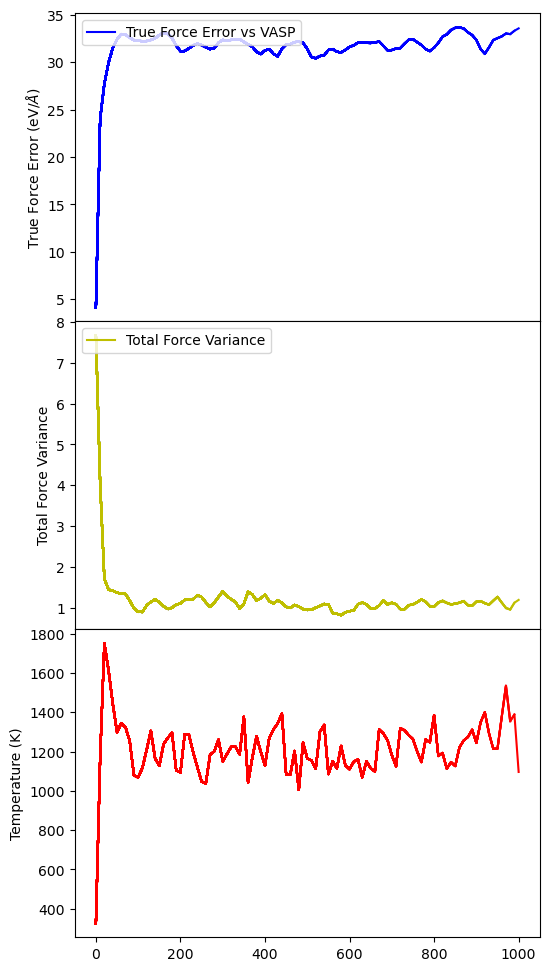

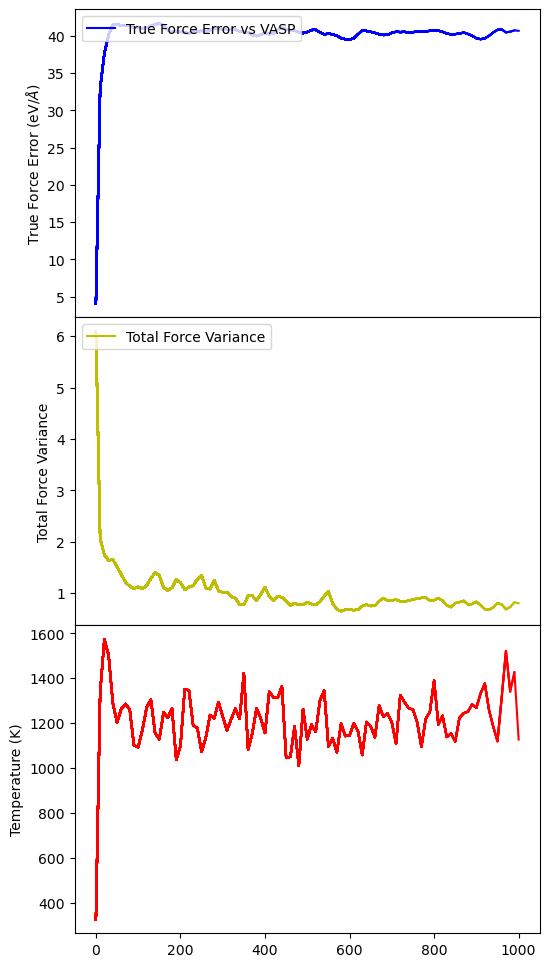

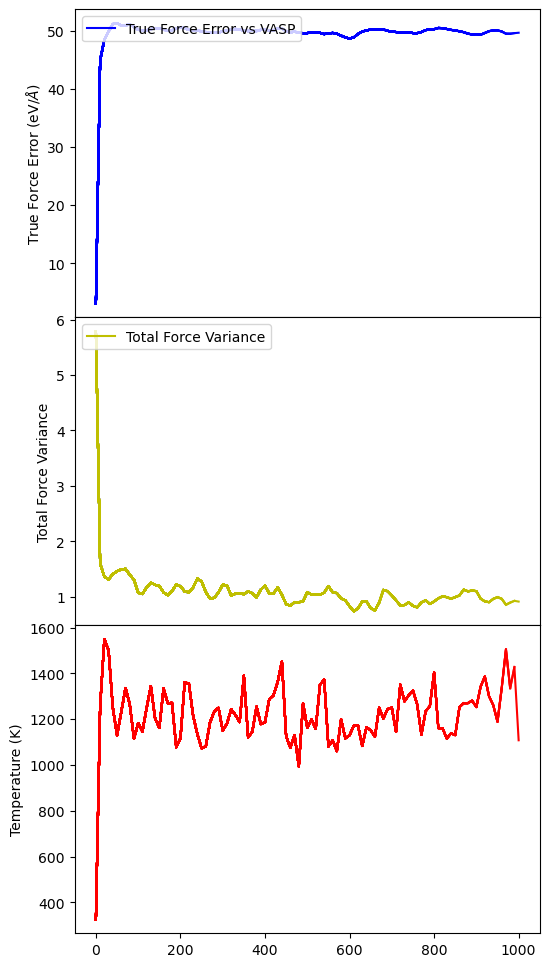

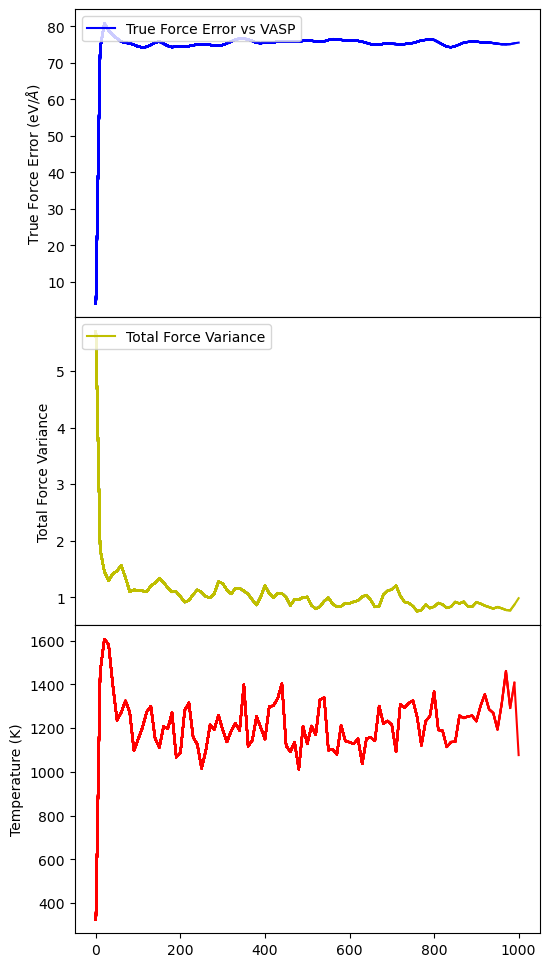

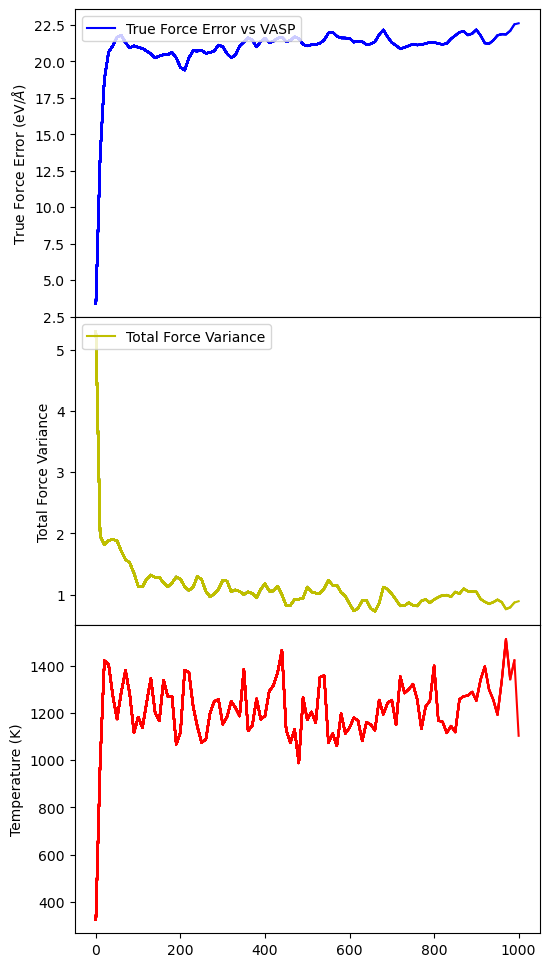

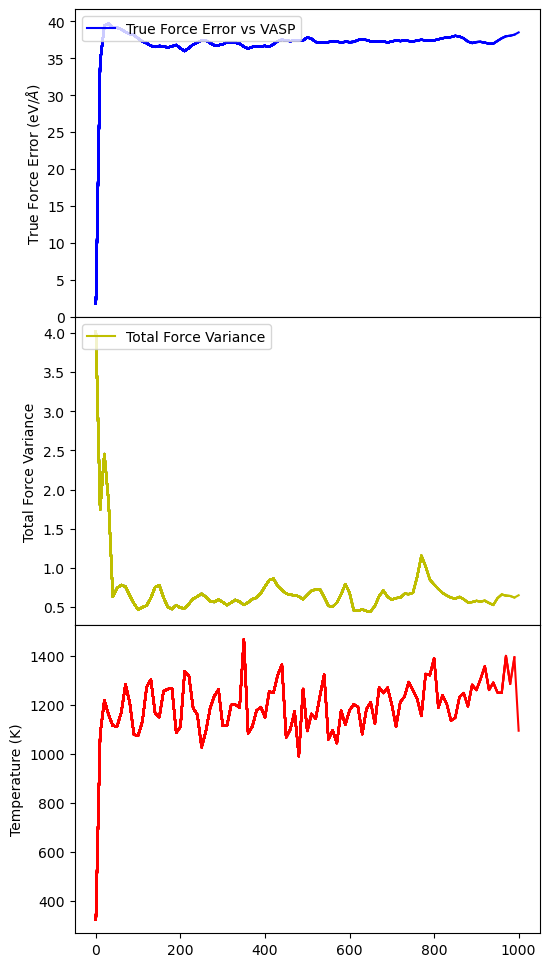

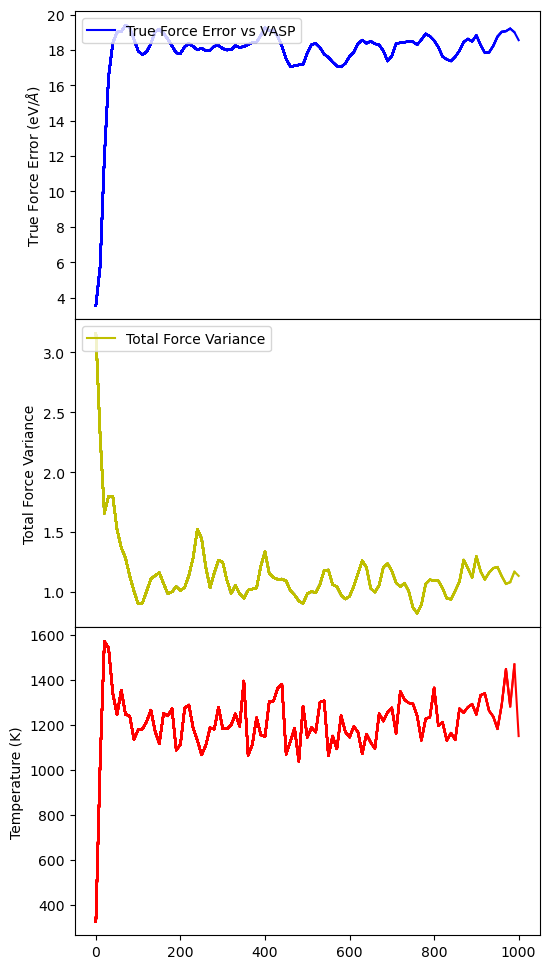

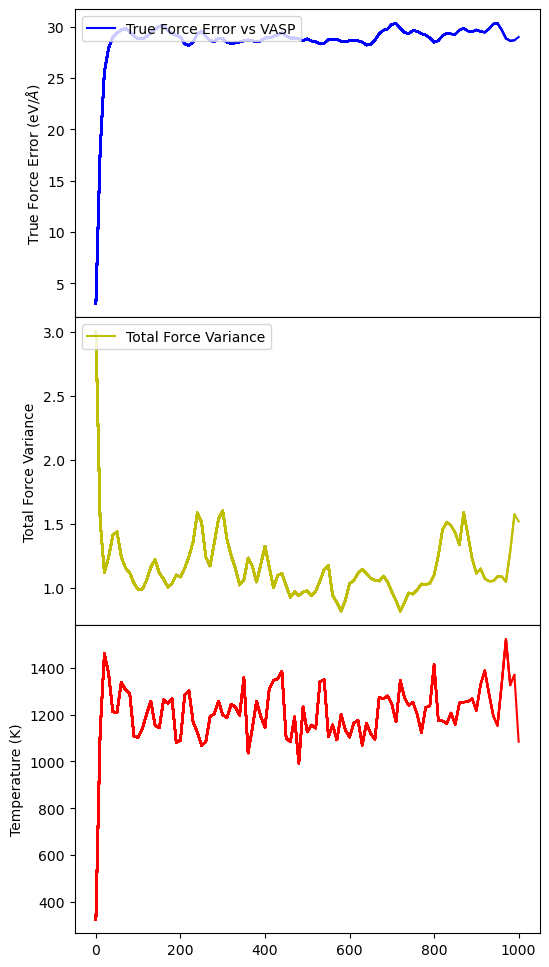

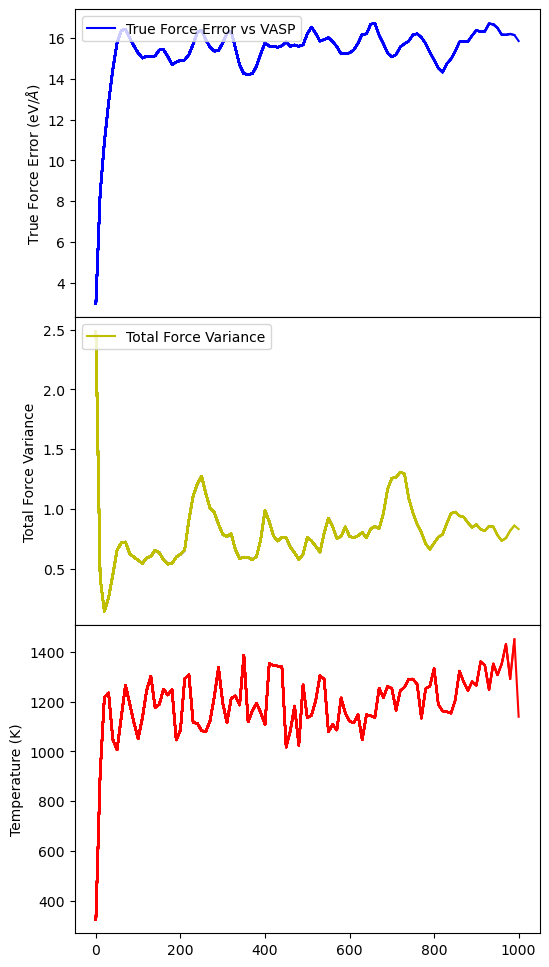

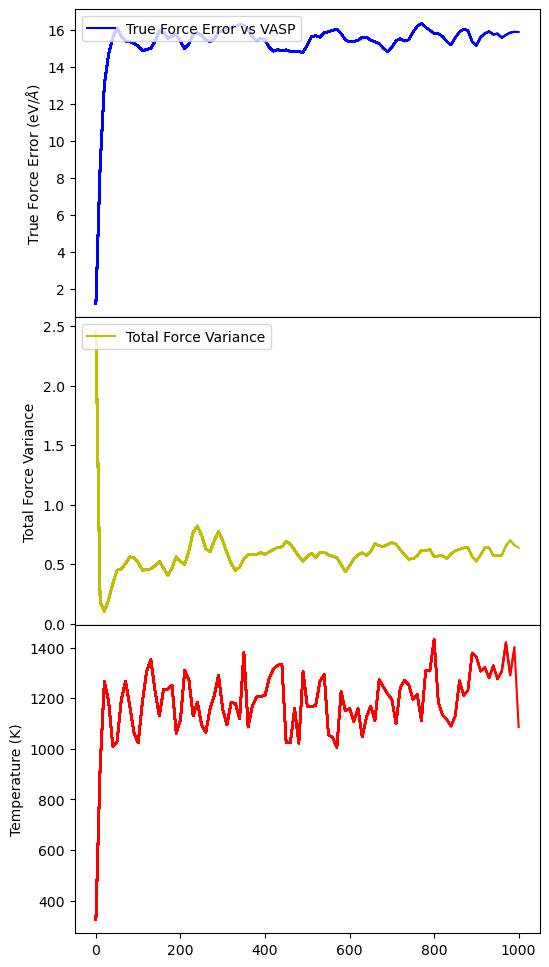

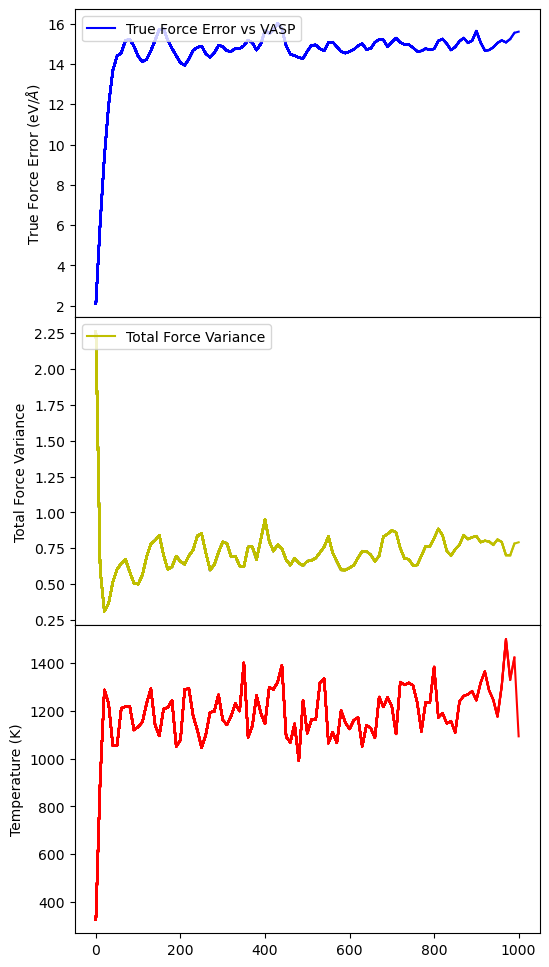

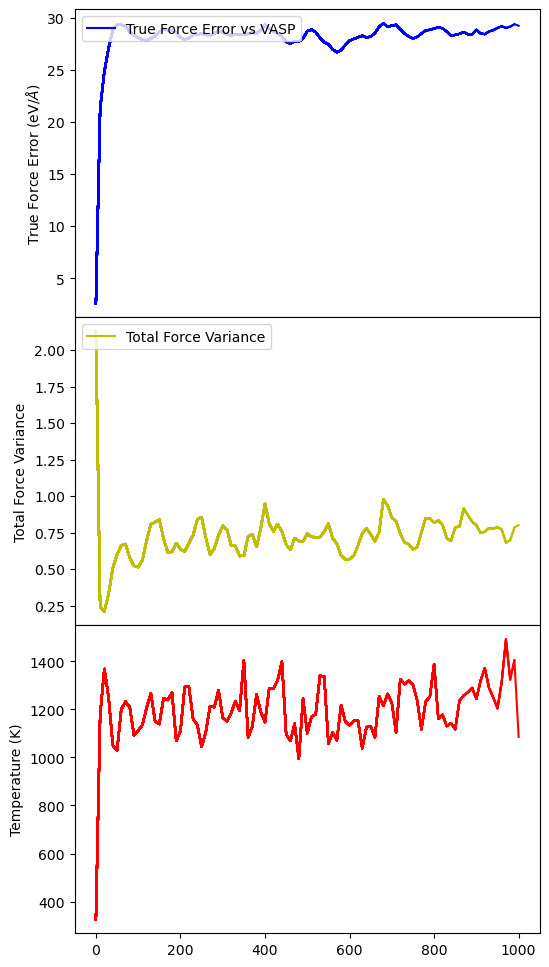

In [14]:
import pylab as pl
# now we run MD on these structures for ~ 1000 fs 
for var_data in top_structures:
    if var_data[0] == 8457:
        continue
    print(f"Running MD on structure {var_data[0]} with total variance {var_data[1]['total_variance']}")
    test_md_frame = data[var_data[0]].copy()
    test_md_frame.calc = mace_calcs

    #initialize the temperature
    np.random.seed(701)
    MaxwellBoltzmannDistribution(test_md_frame, temperature_K=300) #initialize temperature at 300
    Stationary(test_md_frame)
    ZeroRotation(test_md_frame)

    dyn = Langevin(test_md_frame, 1.0*units.fs, temperature_K=1200, friction=0.5)

    %matplotlib inline

    time_fs = []
    temperature = []
    forces_0 = []
    forces_2 = []
    forces_3 = []
    forces_4 = []
    total_variance = []
    per_atom_variance = []
    true_force_errors = []

    fig, ax = pl.subplots(3,1, figsize=(6,12), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
        at = dyn.atoms.copy()
        at.calc = mace_calcs 
        at.get_potential_energies()
        true_forces = at.arrays['REF_force']

        dyn.atoms.write(f"../data/zr-w-v-ti-cr/gen_0_2024-11-06/md_frames/md_top_0_test_{var_data[0]}.xyz", append=True, write_results=False)

        time_fs.append(dyn.get_time()/units.fs)
        temperature.append(dyn.atoms.get_temperature())
        forces_0.append(dyn.atoms.calc.results['forces_comm'][0])
        forces_2.append(dyn.atoms.calc.results['forces_comm'][1])
        forces_3.append(dyn.atoms.calc.results['forces_comm'][2])
        forces_4.append(dyn.atoms.calc.results['forces_comm'][3])
        total_variance.append(calculate_total_variance(dyn.atoms.calc.results['forces_comm']))
        per_atom_variance.append(calculate_per_atom_variance(dyn.atoms.calc.results['forces_comm']))
        # calculate the average and the standard deviation of the RMSE of the forces from the different models 
        true_force_errors.append(np.mean(np.linalg.norm(true_forces - dyn.atoms.calc.results['forces_comm'], axis=1)))

        # plot the true force error 
        ax[0].plot(np.array(time_fs), np.array(true_force_errors), color="b")
        ax[0].set_ylabel('True Force Error (eV/$\AA$)')
        ax[0].legend(["True Force Error vs VASP"], loc = 'upper left')

        # plot the total force variance 
        ax[1].plot(np.array(time_fs), np.array(total_variance), color="y")
        ax[1].set_ylabel('Total Force Variance')
        ax[1].legend(["Total Force Variance"], loc = 'upper left')

        # plot the temperature of the system 
        ax[2].plot(np.array(time_fs), np.array(temperature), color="r")
        ax[2].set_ylabel('Temperature (K)')

        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(0.01)



    dyn.attach(write_frame, interval=10)
    dyn.run(1000)
